# Proyecto de regresión

## Importación de librerías

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    QuantileTransformer
)
from sklearn.metrics import (mean_squared_error, r2_score)

import math

## Funciones auxiliares

In [2]:
def train_models(x_train, y_train, model_dict) -> dict:
    # TODO: Mirar para implementar un GridSearchCV para optimizar hiperparametros
    CV = 5
    
    trained_model_dict = {}
    
    for model_name, model_details in model_dict.items():
        model_class, parameters = model_details
        
        gs_estimator = GridSearchCV(
            estimator = model_class(),
            param_grid = parameters,
            cv = CV
        )
        

        start_time = time.time()
        model.fit(x_train, y_train)
        training_time = time.time() - start_time

        trained_model_dict[model_name] = {
            'model':            model,
            'training_time':    training_time
        }
    
    return trained_model_dict

In [3]:
def predict_models(x_test, y_test, trained_model_dict) -> dict:
    tested_model_dict = {}

    for model_name, model_details in trained_model_dict.items():
        start_time = time.time()
        predicted = model_details['model'].predict(x_test)
        predict_time = time.time() - start_time

        tested_model_dict[model_name] = {
            'prediction_time':      predict_time,
            'prediction':           predicted,
            'mean_squared_error':   mean_squared_error(y_test, predicted),
            'r2_score':             r2_score(y_test, predicted)
        }
    
    return tested_model_dict

In [4]:
def results_to_dataframe(trained_model_dict, tested_model_dict) -> pd.DataFrame:
    name_list =     [name for name in trained_model_dict]
    tr_time_list =  [elem.get('training_time') for elem in trained_model_dict.values()]
    pr_time_list =  [elem.get('prediction_time') for elem in tested_model_dict.values()]
    mse_list =      [elem.get('mean_squared_error') for elem in tested_model_dict.values()]
    r2_list =       [elem.get('r2_score') for elem in tested_model_dict.values()]
    
    return pd.DataFrame({
        'Model': name_list,
        'Mean squared error (MSE)': mse_list,
        'R2 score': r2_list,
        'Training time': tr_time_list,
        'Prediction time': pr_time_list,
    }).sort_values(by='R2 score', ascending=True)

In [5]:
def plot_results(tested_model_dict, y_test):
    MAX_COLS = 3

    n_cols = min(len(tested_model_dict), MAX_COLS)
    n_rows = math.ceil(len(tested_model_dict) / n_cols)

    fig, ax = plt.subplots(
        nrows = n_rows,
        ncols = n_cols,
        figsize = (12, 7),
        gridspec_kw = {
            'hspace': 0.6,
            'wspace': 0.2
        }
    )
    fig.suptitle('Estimaciones realizadas por cada algoritmo')

    i = 0
    j = 0
    for pos, model_name in enumerate(tested_model_dict):
        i = pos // n_cols
        j = pos % n_cols
        
        predicted = tested_model_dict[model_name].get('prediction')

        ax[i][j].set_title(model_name, fontsize = 10)
        ax[i][j].scatter(x = predicted, y = y_test)
        ax[i][j].set_xlabel('Predicho')
        ax[i][j].set_ylabel('Real')

        upper_limit = max(
            max(predicted),
            max(y_test)
        ) * 1.1
        ax[i][j].set_xlim([0, upper_limit])
        ax[i][j].set_ylim([0, upper_limit])

        ax[i][j].plot(
            ax[i][j].get_xlim(),
            ax[i][j].get_ylim(),
            ls='--',
            c='r'
        )

    for i2 in range(i, len(ax)):
        for j2 in range(j + 1, len(ax[0])):
            ax[i2][j2].remove()

## Lectura de ficheros

In [6]:
df = pd.read_csv('../data/input/train_2_pr.csv')

display(df)

,Unnamed: 0,shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected,shipping_time
0,0,S000720,2019-06-08 07:17:51,A,Y,GB,IN,88.61000,355.00,0.7500,Air,SC3,Y,5.00741
1,1,S000725,2019-07-12 15:23:21,A,Y,GB,IN,85.65000,105.00,0.9000,Ocean,SC1,Y,21.41215
2,2,S000736,2019-10-04 14:23:29,A,Y,GB,IN,86.22000,100.00,0.7500,Air,SC3,Y,5.33692
3,3,S000738,2020-01-07 09:19:50,A,Y,GB,IN,94.43000,1071.00,1.0500,Air,SC2,Y,5.14792
4,4,S000739,2020-04-11 06:36:03,A,Y,GB,IN,94.24000,2007.00,0.7500,Air,SC3,Y,5.03067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,5109,S7631147,2020-03-31 10:32:09,A,X,GB,BD,104.86000,304.00,1.1250,Ocean,SC1,Y,15.26933
5110,5110,S9671147,2020-04-05 16:36:06,A,X,GB,BD,103.56125,240.00,0.5625,Ocean,SC2,Y,12.41192
5111,5111,S1407148,2020-04-09 10:59:51,A,X,GB,BD,105.55000,400.00,1.1250,Ocean,SC1,Y,5.68333
5112,5112,S7478148,2020-04-24 15:27:00,A,X,GB,BD,105.95000,398.00,1.1250,Ocean,SC1,Y,41.97199


## Limpieza base de los datos

In [7]:
df.drop(
    columns = [
        'Unnamed: 0',       # Índice sin uso
        'shipment_id',      # ID aleatorio sin significancia
        'pick_up_point',    # Toma un único valor
        'drop_off_point',   # Toma un único valor
        'selected'          # Toma un único valor
    ],
    inplace = True
)

display(df)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,2019-06-08 07:17:51,GB,IN,88.61000,355.00,0.7500,Air,SC3,5.00741
1,2019-07-12 15:23:21,GB,IN,85.65000,105.00,0.9000,Ocean,SC1,21.41215
2,2019-10-04 14:23:29,GB,IN,86.22000,100.00,0.7500,Air,SC3,5.33692
3,2020-01-07 09:19:50,GB,IN,94.43000,1071.00,1.0500,Air,SC2,5.14792
4,2020-04-11 06:36:03,GB,IN,94.24000,2007.00,0.7500,Air,SC3,5.03067
...,...,...,...,...,...,...,...,...,...
5109,2020-03-31 10:32:09,GB,BD,104.86000,304.00,1.1250,Ocean,SC1,15.26933
5110,2020-04-05 16:36:06,GB,BD,103.56125,240.00,0.5625,Ocean,SC2,12.41192
5111,2020-04-09 10:59:51,GB,BD,105.55000,400.00,1.1250,Ocean,SC1,5.68333
5112,2020-04-24 15:27:00,GB,BD,105.95000,398.00,1.1250,Ocean,SC1,41.97199


## Escenarios de regresión

### 01 - Etiquetado de características categóricas + timestamp a segundos

In [8]:
df_01 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_01[col] = LabelEncoder().fit_transform(df_01[col])


# Conversión a segundos desde Epoch
df_01['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9


display(df_01)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,1559978271,0,1,88.61000,355.00,0.7500,0,2,5.00741
1,1562945001,0,1,85.65000,105.00,0.9000,1,0,21.41215
2,1570199009,0,1,86.22000,100.00,0.7500,0,2,5.33692
3,1578388790,0,1,94.43000,1071.00,1.0500,0,1,5.14792
4,1586586963,0,1,94.24000,2007.00,0.7500,0,2,5.03067
...,...,...,...,...,...,...,...,...,...
5109,1585650729,0,0,104.86000,304.00,1.1250,1,0,15.26933
5110,1586104566,0,0,103.56125,240.00,0.5625,1,1,12.41192
5111,1586429991,0,0,105.55000,400.00,1.1250,1,0,5.68333
5112,1587742020,0,0,105.95000,398.00,1.1250,1,0,41.97199


In [9]:
X = df_01.drop(columns=['shipping_time'])
y = df_01['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:

# NOTE: Se pueden cambiar todos estos diccionarios para definirlos únicamente una vez al principio con sus opciones de optimizado
# y así evito repetirlos cada vez
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor':      AdaBoostRegressor(),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
2,SVR sigmoid,165.864526,-0.501101,1.202568,0.302490
1,SVR rbf,165.500810,-0.497809,1.086837,0.698781
0,SVR poly,162.839505,-0.473724,0.889347,0.122713
6,KNN Regressor,118.652856,-0.073827,0.006604,0.009648
3,Decision Tree Regressor,97.704094,0.115762,0.079860,0.001000
4,Random Forest Regressor,54.515020,0.506630,5.553864,0.040730
5,Ada Boost Regressor,46.612860,0.578146,0.071831,0.004521


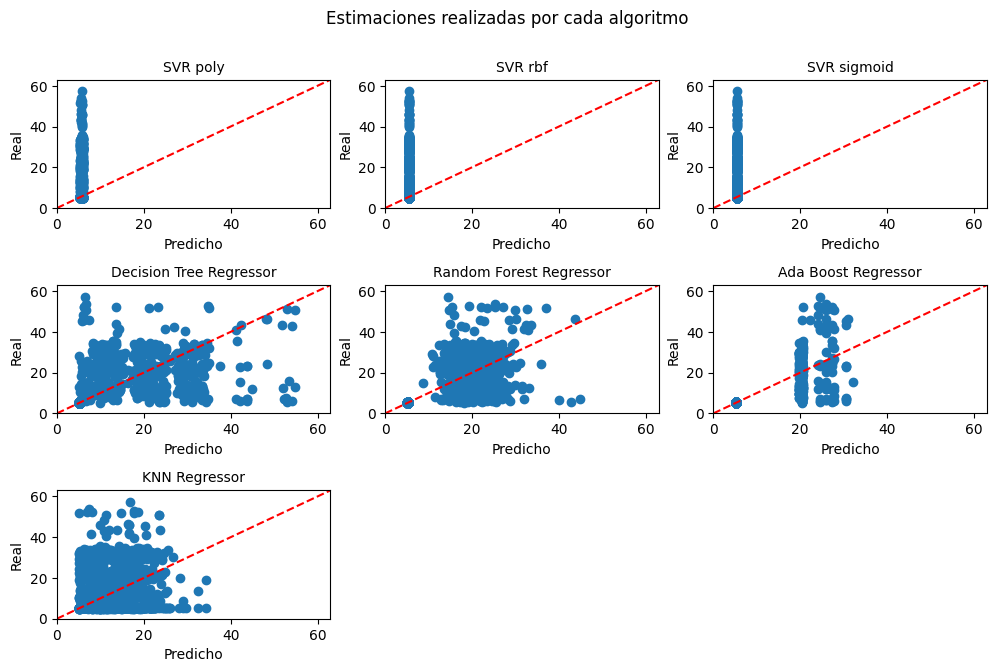

In [11]:
plot_results(test_results, y_test)

### 02 - Etiquetado de características + timestamp a segundos + normalizado por z_score

In [12]:
df_02 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_02[col] = LabelEncoder().fit_transform(df_02[col])


# Conversión a segundos desde Epoch
df_02['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_02[col] = StandardScaler().fit_transform(df_02[[col]])[:,0]

display(df_02)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,1559978271,0,1,-0.502717,-0.473210,-0.951330,0,2,-0.743214
1,1562945001,0,1,-1.077047,-0.670686,0.220913,1,0,0.853796
2,1570199009,0,1,-0.966450,-0.674635,-0.951330,0,2,-0.711136
3,1578388790,0,1,0.626539,0.092360,1.393156,0,1,-0.729535
4,1586586963,0,1,0.589673,0.831709,-0.951330,0,2,-0.740950
...,...,...,...,...,...,...,...,...,...
5109,1585650729,0,0,2.650274,-0.513495,1.979277,1,0,0.255789
5110,1586104566,0,0,2.398277,-0.564049,-2.416633,1,1,-0.022381
5111,1586429991,0,0,2.784155,-0.437665,1.979277,1,0,-0.677413
5112,1587742020,0,0,2.861767,-0.439244,1.979277,1,0,2.855307


In [13]:
X = df_02.drop(columns=['shipping_time'])
y = df_02['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor':      AdaBoostRegressor(),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
2,SVR sigmoid,1.302299,-0.351768,0.951070,0.331541
1,SVR rbf,1.279535,-0.328140,0.813288,0.620104
0,SVR poly,1.237735,-0.284751,0.588873,0.127027
6,KNN Regressor,1.124767,-0.167493,0.006080,0.005584
3,Decision Tree Regressor,0.853871,0.113694,0.068583,0.002049
4,Random Forest Regressor,0.486265,0.495263,5.170506,0.039898
5,Ada Boost Regressor,0.439366,0.543944,0.107968,0.003999


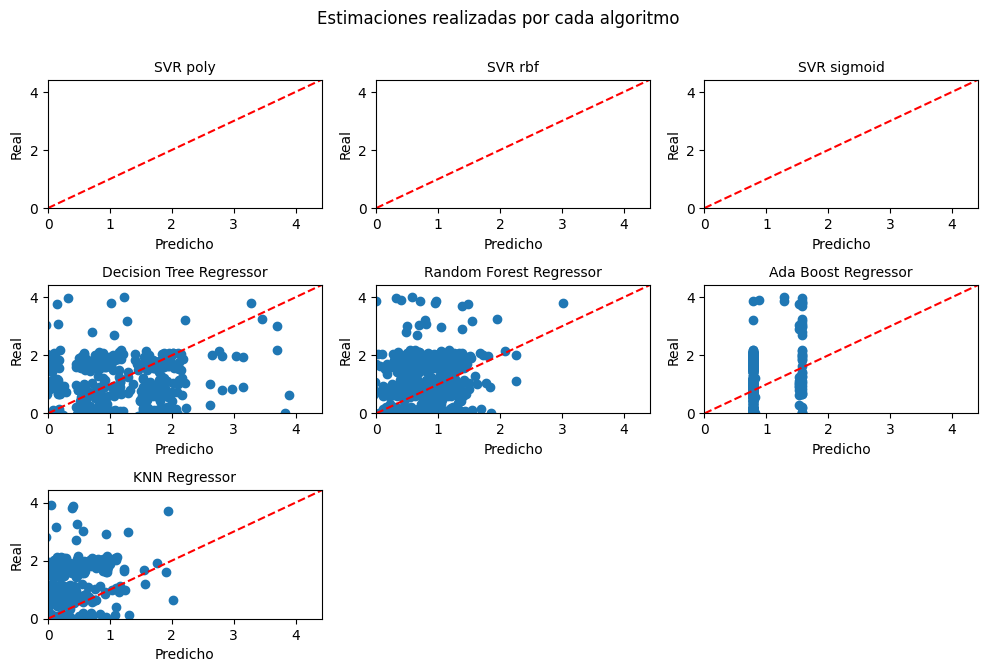

In [15]:
plot_results(test_results, y_test)

### 03 - Etiquetado + timestamp + MinMax scaling

In [16]:
df_03 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_03[col] = LabelEncoder().fit_transform(df_03[col])


# Conversión a segundos desde Epoch
df_03['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_03[col] = MinMaxScaler().fit_transform(df_03[[col]])[:,0]

display(df_03)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,1559978271,0,1,0.174874,0.035018,0.333333,0,2,0.000142
1,1562945001,0,1,0.084449,0.010005,0.600000,1,0,0.314110
2,1570199009,0,1,0.101862,0.009505,0.333333,0,2,0.006448
3,1578388790,0,1,0.352669,0.106653,0.866667,0,1,0.002831
4,1586586963,0,1,0.346864,0.200300,0.333333,0,2,0.000587
...,...,...,...,...,...,...,...,...,...
5109,1585650729,0,0,0.671294,0.029915,1.000000,1,0,0.196544
5110,1586104566,0,0,0.631618,0.023512,0.000000,1,1,0.141856
5111,1586429991,0,0,0.692373,0.039520,1.000000,1,0,0.013078
5112,1587742020,0,0,0.704592,0.039320,1.000000,1,0,0.707603


In [17]:
X = df_03.drop(columns=['shipping_time'])
y = df_03['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [18]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor':      AdaBoostRegressor(),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
6,KNN Regressor,0.042850,-0.098445,0.004462,0.009701
2,SVR sigmoid,0.042287,-0.084009,0.733875,0.226244
1,SVR rbf,0.040807,-0.046063,0.573090,0.443117
0,SVR poly,0.040791,-0.045655,0.503698,0.111399
3,Decision Tree Regressor,0.031851,0.183532,0.077818,0.000998
4,Random Forest Regressor,0.019279,0.505793,5.166188,0.039964
5,Ada Boost Regressor,0.016937,0.565820,0.114522,0.005265


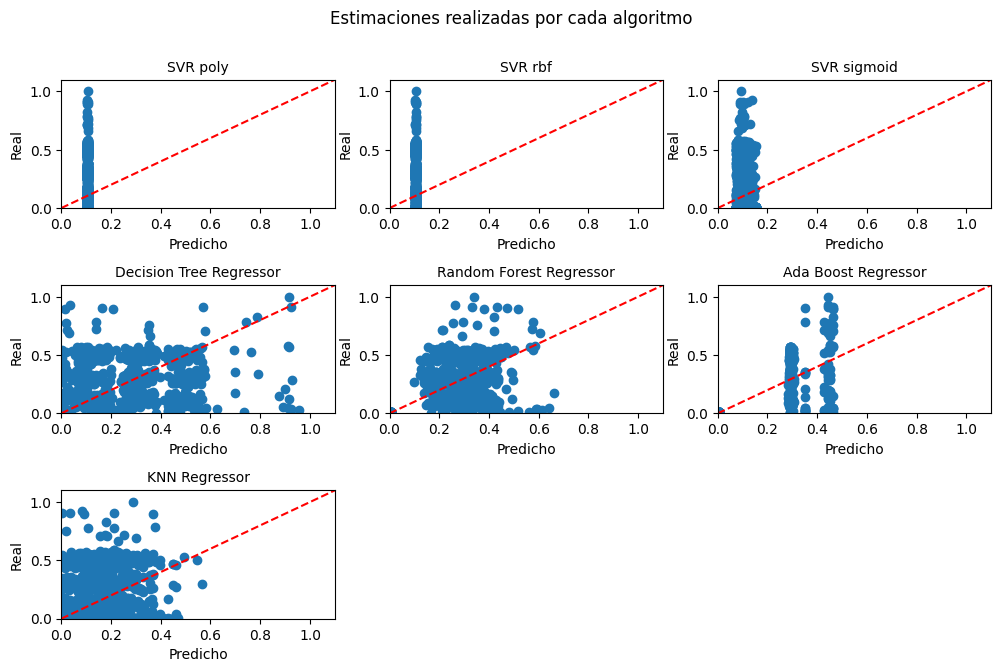

In [19]:
plot_results(test_results, y_test)

### 04 - Etiquetado + timestamp + RobustScaller

In [20]:
df_04 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_04[col] = LabelEncoder().fit_transform(df_04[col])


# Conversión a segundos desde Epoch
df_04['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_04[col] = RobustScaler().fit_transform(df_04[[col]])[:,0]

display(df_04)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,1559978271,0,1,-0.420639,-0.171429,-1.00,0,2,-0.027536
1,1562945001,0,1,-1.002457,-0.457143,0.00,1,0,1.108183
2,1570199009,0,1,-0.890418,-0.462857,-1.00,0,2,-0.004724
3,1578388790,0,1,0.723342,0.646857,1.00,0,1,-0.017808
4,1586586963,0,1,0.685995,1.716571,-1.00,0,2,-0.025926
...,...,...,...,...,...,...,...,...,...
5109,1585650729,0,0,2.773464,-0.229714,1.50,1,0,0.682909
5110,1586104566,0,0,2.518182,-0.302857,-2.25,1,1,0.485087
5111,1586429991,0,0,2.909091,-0.120000,1.50,1,0,0.019259
5112,1587742020,0,0,2.987715,-0.122286,1.50,1,0,2.531565


In [21]:
X = df_04.drop(columns=['shipping_time'])
y = df_04['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor':      AdaBoostRegressor(),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
2,SVR sigmoid,0.685735,-0.328532,0.855263,0.285163
1,SVR rbf,0.681099,-0.319550,0.783008,0.651973
0,SVR poly,0.674377,-0.306526,0.619169,0.115868
6,KNN Regressor,0.566454,-0.097439,0.005605,0.005511
3,Decision Tree Regressor,0.458439,0.111829,0.073707,0.001996
4,Random Forest Regressor,0.253640,0.508601,5.282648,0.040146
5,Ada Boost Regressor,0.214055,0.585294,0.103918,0.004933


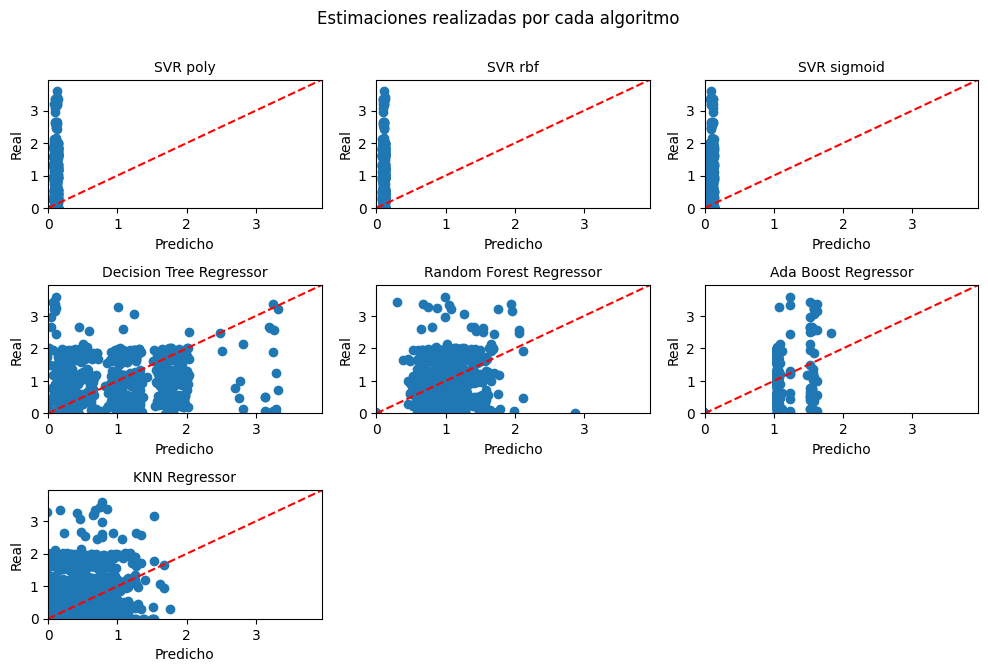

In [23]:
plot_results(test_results, y_test)

### 05 - Etiquetado + timestamp + QuantileTransformer

In [24]:
df_05 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_05[col] = LabelEncoder().fit_transform(df_05[col])


# Conversión a segundos desde Epoch
df_05['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_05[col] = QuantileTransformer().fit_transform(df_05[[col]])

display(df_05)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,1559978271,0,1,0.311521,0.395896,0.201702,0,2,0.008233
1,1562945001,0,1,0.078579,0.081582,0.574074,1,0,0.789785
2,1570199009,0,1,0.121095,0.064565,0.201702,0,2,0.417803
3,1578388790,0,1,0.898880,0.741809,0.882883,0,1,0.184774
4,1586586963,0,1,0.890891,0.876376,0.201702,0,2,0.037231
...,...,...,...,...,...,...,...,...,...
5109,1585650729,0,0,0.953476,0.340340,1.000000,1,0,0.694697
5110,1586104566,0,0,0.947864,0.273273,0.000000,1,1,0.654626
5111,1586429991,0,0,0.955619,0.421421,1.000000,1,0,0.526478
5112,1587742020,0,0,0.957694,0.416166,1.000000,1,0,0.989116


In [25]:
X = df_05.drop(columns=['shipping_time'])
y = df_05['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor (linear)':         AdaBoostRegressor(loss='linear'),
    'Ada Boost Regressor (square)' :        AdaBoostRegressor(loss='square'),
    'Ada Boost Regressor (exponential)':    AdaBoostRegressor(loss='exponential'),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
8,KNN Regressor,0.093275,-0.110419,0.004512,0.008013
2,SVR sigmoid,0.084746,-0.008885,0.895437,0.239030
0,SVR poly,0.083733,0.003180,0.536768,0.087205
1,SVR rbf,0.083098,0.010736,0.755300,0.456946
3,Decision Tree Regressor,0.044503,0.470207,0.090238,0.001524
7,Ada Boost Regressor (exponential),0.024687,0.706106,0.388566,0.013527
6,Ada Boost Regressor (square),0.024668,0.706338,0.134305,0.004522
4,Random Forest Regressor,0.024545,0.707803,5.257597,0.039108
5,Ada Boost Regressor (linear),0.022566,0.731358,0.123764,0.005509


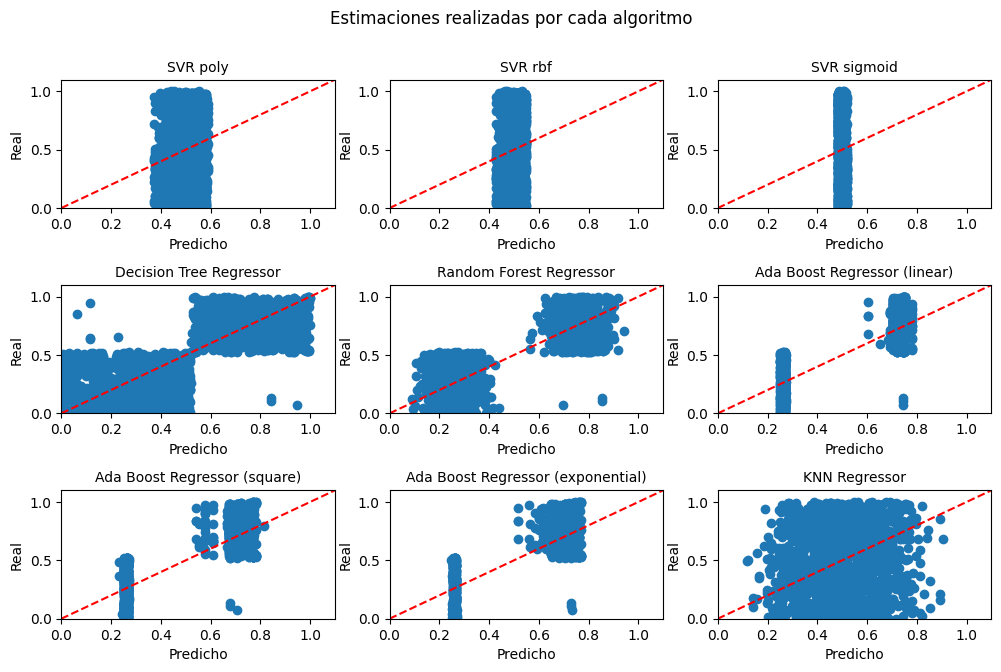

In [27]:
plot_results(test_results, y_test)

### 06 - Etiquetado + timestamp labeling

In [28]:
df_06 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_06[col] = LabelEncoder().fit_transform(df_06[col])

# Conversión de tiempo a categorias
df_06['send_timestamp'] = pd.to_datetime(df_06['send_timestamp'])
df_06["year"] =         df_06["send_timestamp"].dt.year
df_06["month"] =        df_06["send_timestamp"].dt.month
df_06["day"] =          df_06["send_timestamp"].dt.day
df_06["dayofweek"] =    df_06["send_timestamp"].dt.day_of_week
df_06["dayofyear"] =    df_06["send_timestamp"].dt.day_of_year
df_06["hour"] =         df_06["send_timestamp"].dt.hour
df_06["minute"] =       df_06["send_timestamp"].dt.minute
df_06.drop(columns="send_timestamp", inplace=True)

display(df_06)

,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time,year,month,day,dayofweek,dayofyear,hour,minute
0,0,1,88.61000,355.00,0.7500,0,2,5.00741,2019,6,8,5,159,7,17
1,0,1,85.65000,105.00,0.9000,1,0,21.41215,2019,7,12,4,193,15,23
2,0,1,86.22000,100.00,0.7500,0,2,5.33692,2019,10,4,4,277,14,23
3,0,1,94.43000,1071.00,1.0500,0,1,5.14792,2020,1,7,1,7,9,19
4,0,1,94.24000,2007.00,0.7500,0,2,5.03067,2020,4,11,5,102,6,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,0,0,104.86000,304.00,1.1250,1,0,15.26933,2020,3,31,1,91,10,32
5110,0,0,103.56125,240.00,0.5625,1,1,12.41192,2020,4,5,6,96,16,36
5111,0,0,105.55000,400.00,1.1250,1,0,5.68333,2020,4,9,3,100,10,59
5112,0,0,105.95000,398.00,1.1250,1,0,41.97199,2020,4,24,4,115,15,27


In [29]:
X = df_06.drop(columns=['shipping_time'])
y = df_06['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [30]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor (linear)':         AdaBoostRegressor(loss='linear'),
    'Ada Boost Regressor (square)' :        AdaBoostRegressor(loss='square'),
    'Ada Boost Regressor (exponential)':    AdaBoostRegressor(loss='exponential'),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
2,SVR sigmoid,839.179528,-6.599222,0.997298,0.295071
0,SVR poly,144.364316,-0.307297,0.856297,0.137155
1,SVR rbf,143.110902,-0.295946,0.899384,0.682354
8,KNN Regressor,116.200373,-0.052257,0.009009,0.016036
3,Decision Tree Regressor,79.692868,0.278338,0.102574,0.002004
7,Ada Boost Regressor (exponential),62.553168,0.433547,0.383423,0.015073
6,Ada Boost Regressor (square),47.517423,0.569704,0.306389,0.019073
4,Random Forest Regressor,46.378133,0.580021,7.088012,0.040678
5,Ada Boost Regressor (linear),41.735083,0.622066,0.072767,0.006937


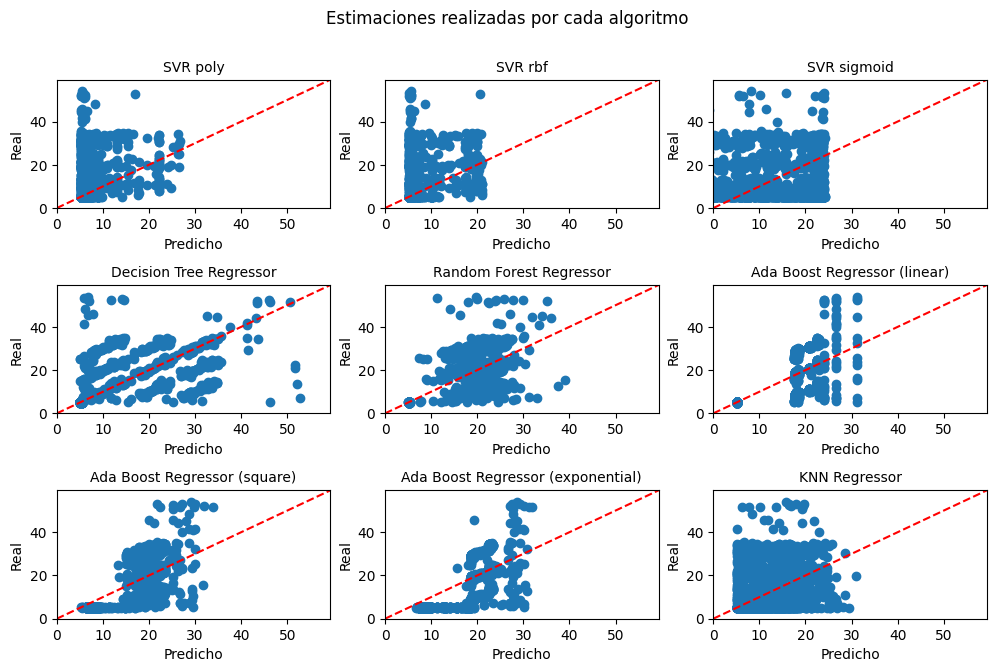

In [31]:
plot_results(test_results, y_test)

### 07 - etiquetado + timestamp labeling + quantile normalization

In [32]:
df_07 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_07[col] = LabelEncoder().fit_transform(df_07[col])

# Conversión de tiempo a categorias
df_07['send_timestamp'] = pd.to_datetime(df_07['send_timestamp'])
df_07["year"] =         df_07["send_timestamp"].dt.year
df_07["month"] =        df_07["send_timestamp"].dt.month
df_07["day"] =          df_07["send_timestamp"].dt.day
df_07["dayofweek"] =    df_07["send_timestamp"].dt.day_of_week
df_07["dayofyear"] =    df_07["send_timestamp"].dt.day_of_year
df_07["hour"] =         df_07["send_timestamp"].dt.hour
df_07["minute"] =       df_07["send_timestamp"].dt.minute
df_07.drop(columns="send_timestamp", inplace=True)

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_07[col] = QuantileTransformer().fit_transform(df_07[[col]])

display(df_07)

,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time,year,month,day,dayofweek,dayofyear,hour,minute
0,0,1,0.311521,0.395896,0.201702,0,2,0.008233,2019,6,8,5,159,7,17
1,0,1,0.078579,0.081582,0.574074,1,0,0.789785,2019,7,12,4,193,15,23
2,0,1,0.121095,0.064565,0.201702,0,2,0.417803,2019,10,4,4,277,14,23
3,0,1,0.898880,0.741809,0.882883,0,1,0.184774,2020,1,7,1,7,9,19
4,0,1,0.890891,0.876376,0.201702,0,2,0.037231,2020,4,11,5,102,6,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,0,0,0.953476,0.340340,1.000000,1,0,0.694697,2020,3,31,1,91,10,32
5110,0,0,0.947864,0.273273,0.000000,1,1,0.654626,2020,4,5,6,96,16,36
5111,0,0,0.955619,0.421421,1.000000,1,0,0.526478,2020,4,9,3,100,10,59
5112,0,0,0.957694,0.416166,1.000000,1,0,0.989116,2020,4,24,4,115,15,27


In [33]:
X = df_07.drop(columns=['shipping_time'])
y = df_07['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor (linear)':         AdaBoostRegressor(loss='linear'),
    'Ada Boost Regressor (square)' :        AdaBoostRegressor(loss='square'),
    'Ada Boost Regressor (exponential)':    AdaBoostRegressor(loss='exponential'),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
8,KNN Regressor,0.088803,-0.076895,0.008045,0.012624
2,SVR sigmoid,0.082578,-0.001408,0.893104,0.300485
1,SVR rbf,0.081806,0.007961,0.771658,0.658471
0,SVR poly,0.081150,0.015907,0.628679,0.129441
3,Decision Tree Regressor,0.040260,0.511776,0.098302,0.002590
4,Random Forest Regressor,0.022421,0.728107,7.244573,0.038231
6,Ada Boost Regressor (square),0.021334,0.741289,0.339339,0.020766
5,Ada Boost Regressor (linear),0.021289,0.741835,0.204870,0.006556
7,Ada Boost Regressor (exponential),0.021274,0.742011,0.477237,0.015182


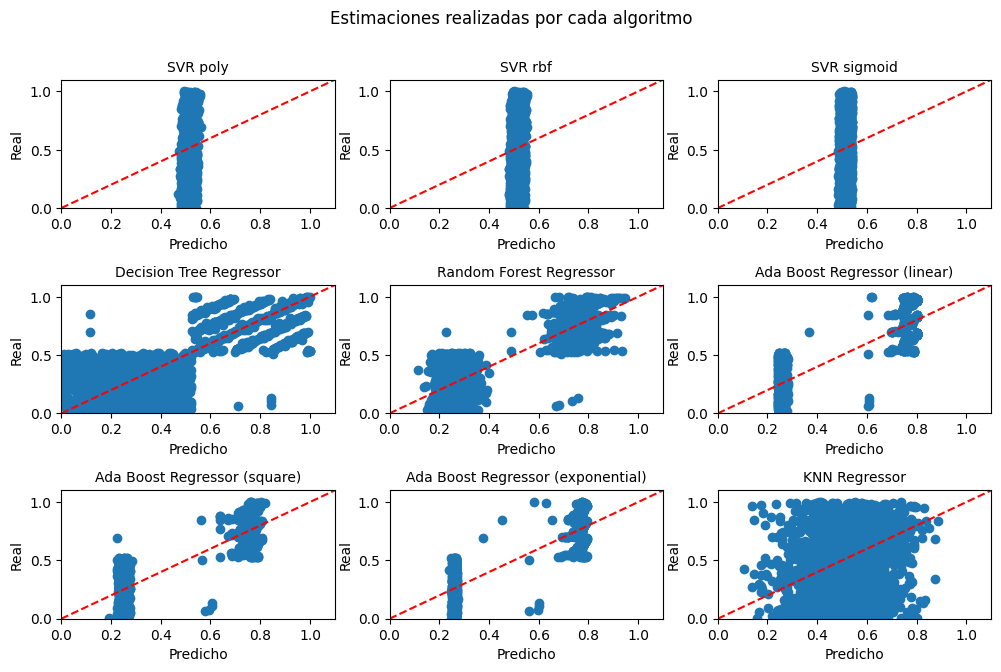

In [35]:
plot_results(test_results, y_test)

### 08 - Etiquetado + timestamp labeling extrayendo minutos + quantile normalization

In [36]:
df_08 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_08[col] = LabelEncoder().fit_transform(df_08[col])

# Conversión de tiempo a categorias
df_08['send_timestamp'] = pd.to_datetime(df_08['send_timestamp'])
df_08["year"] =         df_08["send_timestamp"].dt.year
df_08["month"] =        df_08["send_timestamp"].dt.month
df_08["day"] =          df_08["send_timestamp"].dt.day
df_08["dayofweek"] =    df_08["send_timestamp"].dt.day_of_week
df_08["dayofyear"] =    df_08["send_timestamp"].dt.day_of_year
df_08["hour"] =         df_08["send_timestamp"].dt.hour
df_08["minute"] =       df_08["send_timestamp"].dt.minute
df_08.drop(columns="send_timestamp", inplace=True)

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_08[col] = QuantileTransformer().fit_transform(df_08[[col]])

display(df_08)

,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time,year,month,day,dayofweek,dayofyear,hour,minute
0,0,1,0.311521,0.395896,0.201702,0,2,0.008233,2019,6,8,5,159,7,17
1,0,1,0.078579,0.081582,0.574074,1,0,0.789785,2019,7,12,4,193,15,23
2,0,1,0.121095,0.064565,0.201702,0,2,0.417803,2019,10,4,4,277,14,23
3,0,1,0.898880,0.741809,0.882883,0,1,0.184774,2020,1,7,1,7,9,19
4,0,1,0.890891,0.876376,0.201702,0,2,0.037231,2020,4,11,5,102,6,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,0,0,0.953476,0.340340,1.000000,1,0,0.694697,2020,3,31,1,91,10,32
5110,0,0,0.947864,0.273273,0.000000,1,1,0.654626,2020,4,5,6,96,16,36
5111,0,0,0.955619,0.421421,1.000000,1,0,0.526478,2020,4,9,3,100,10,59
5112,0,0,0.957694,0.416166,1.000000,1,0,0.989116,2020,4,24,4,115,15,27


In [37]:
X = df_08.drop(columns=['shipping_time'])
y = df_08['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [38]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor (linear)':         AdaBoostRegressor(loss='linear'),
    'Ada Boost Regressor (square)' :        AdaBoostRegressor(loss='square'),
    'Ada Boost Regressor (exponential)':    AdaBoostRegressor(loss='exponential'),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
8,KNN Regressor,0.089925,-0.075818,0.008595,0.016759
2,SVR sigmoid,0.083550,0.000449,0.913720,0.265373
1,SVR rbf,0.082991,0.007130,0.772658,0.617047
0,SVR poly,0.082405,0.014148,0.599805,0.143676
3,Decision Tree Regressor,0.041876,0.499010,0.084120,0.000999
4,Random Forest Regressor,0.022941,0.725539,7.438552,0.037499
6,Ada Boost Regressor (square),0.021474,0.743096,0.337837,0.016195
7,Ada Boost Regressor (exponential),0.021213,0.746223,0.421254,0.016561
5,Ada Boost Regressor (linear),0.021166,0.746780,0.188035,0.009620


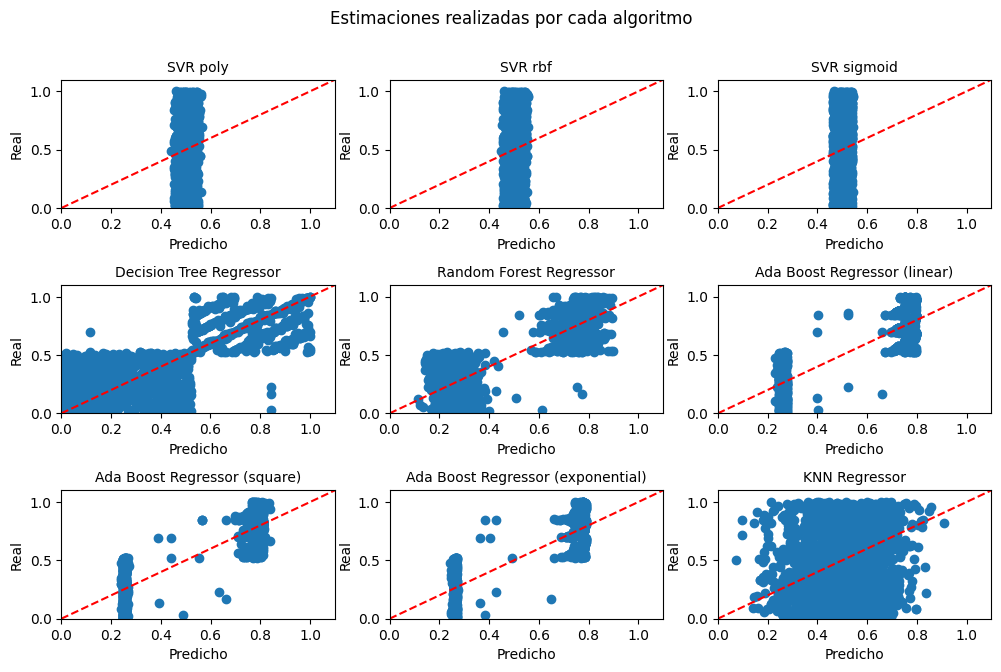

In [39]:
plot_results(test_results, y_test)

### 09 - Etiquetado + timestamp labeling + quantile normalization + feature extraction (rfe)

In [40]:
df_09 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_09[col] = LabelEncoder().fit_transform(df_09[col])

# Conversión de tiempo a categorias
df_09['send_timestamp'] = pd.to_datetime(df_09['send_timestamp'])
df_09["year"] =         df_09["send_timestamp"].dt.year
df_09["month"] =        df_09["send_timestamp"].dt.month
df_09["day"] =          df_09["send_timestamp"].dt.day
df_09["dayofweek"] =    df_09["send_timestamp"].dt.day_of_week
df_09["dayofyear"] =    df_09["send_timestamp"].dt.day_of_year
df_09["hour"] =         df_09["send_timestamp"].dt.hour
df_09["minute"] =       df_09["send_timestamp"].dt.minute
df_09.drop(columns="send_timestamp", inplace=True)

# Normalizado de variables numéricas por Quantile
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_09[col] = QuantileTransformer().fit_transform(df_09[[col]])


# Extracción de características por Recursive Feature Elimination
rfe_selector = RFE(
    estimator = RandomForestRegressor(),
    n_features_to_select = 5,
    step = 1
)
X = df_09.drop(columns=['shipping_time'])
y = df_09['shipping_time']
rfe_selector.fit(X, y)

selected_features = []
for i, feature in enumerate(rfe_selector.support_):
    if feature:
        selected_features.append(X.columns[i])
selected_features.append('shipping_time')

df_09 = df_09.filter(selected_features)

display(df_09)

,freight_cost,gross_weight,shipment_mode,dayofyear,minute,shipping_time
0,0.311521,0.395896,0,159,17,0.008233
1,0.078579,0.081582,1,193,23,0.789785
2,0.121095,0.064565,0,277,23,0.417803
3,0.898880,0.741809,0,7,19,0.184774
4,0.890891,0.876376,0,102,36,0.037231
...,...,...,...,...,...,...
5109,0.953476,0.340340,1,91,32,0.694697
5110,0.947864,0.273273,1,96,36,0.654626
5111,0.955619,0.421421,1,100,59,0.526478
5112,0.957694,0.416166,1,115,27,0.989116


In [41]:
X = df_09.drop(columns=['shipping_time'])
y = df_09['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [42]:
train_results = train_models(X_train, y_train, {
    'SVR poly':                 SVR(kernel='poly'),
    'SVR rbf':                  SVR(kernel='rbf'),
    'SVR sigmoid':              SVR(kernel='sigmoid'),
    'Decision Tree Regressor':  DecisionTreeRegressor(),
    'Random Forest Regressor':  RandomForestRegressor(),
    'Ada Boost Regressor (linear)':         AdaBoostRegressor(loss='linear'),
    'Ada Boost Regressor (square)' :        AdaBoostRegressor(loss='square'),
    'Ada Boost Regressor (exponential)':    AdaBoostRegressor(loss='exponential'),
    'KNN Regressor':            KNeighborsRegressor()
})

test_results = predict_models(X_test, y_test, train_results)

display(results_to_dataframe(train_results, test_results))

,Model,Mean squared error (MSE),R2 score,Training time,Prediction time
2,SVR sigmoid,13610.686054,-161926.602050,1.073374,0.244777
8,KNN Regressor,0.088505,-0.052953,0.007048,0.009530
1,SVR rbf,0.071795,0.145851,0.743120,0.587279
0,SVR poly,0.059920,0.287132,0.684595,0.098103
3,Decision Tree Regressor,0.043550,0.481886,0.082975,0.001997
6,Ada Boost Regressor (square),0.026610,0.683420,0.262226,0.032258
7,Ada Boost Regressor (exponential),0.024866,0.704162,0.328084,0.024105
4,Random Forest Regressor,0.023364,0.722036,5.722253,0.041982
5,Ada Boost Regressor (linear),0.022133,0.736678,0.107465,0.006026


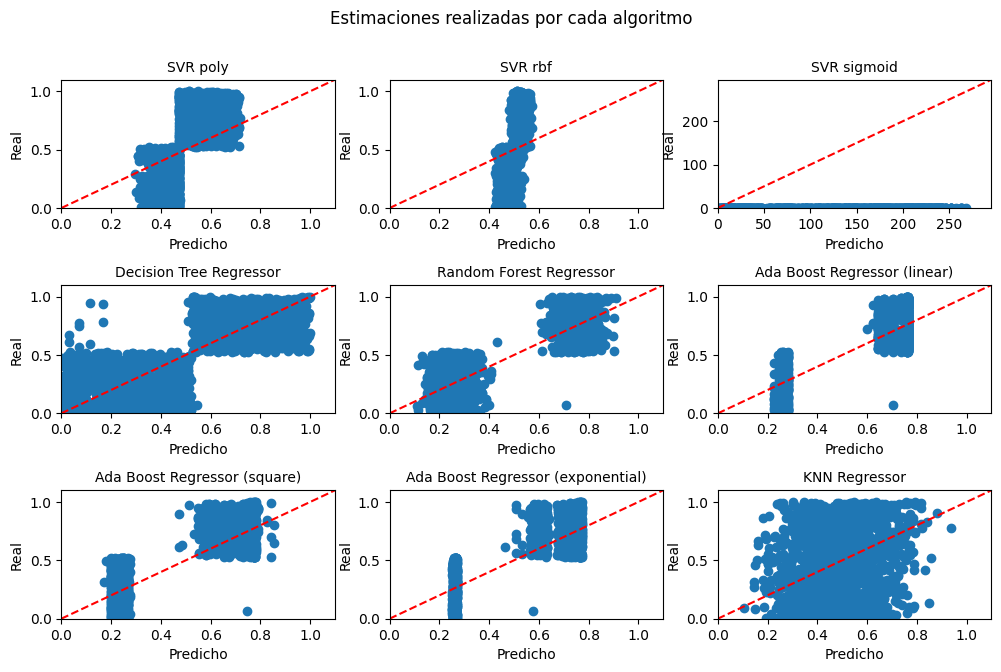

In [46]:
plot_results(test_results, y_test)